In [ ]:

%pip install azure-storage-blob

%pip install pdfplumber

!python -m spacy download en_core_web_sm

%pip install prettytable

In [ ]:
dbutils.library.restartPython()

In [ ]:
from azure.storage.blob import BlobServiceClient
from pyspark.sql.functions import *

HERE HAS THE AZURE BLOB STUP WHICH I CAN'T SHARE 

In [ ]:
import pdfplumber
from io import BytesIO

def extract_text(binary_data):
  pdf_file = BytesIO(binary_data)

  with pdfplumber.open(pdf_file) as pdf:
    plain_text = ""

    for page in pdf.pages:
      plain_text += page.extract_text()

    return plain_text


In [ ]:
binary_pdf = pdf_df.select("content").collect()[0]["content"] 

extracted_text = extract_text(binary_pdf) 
#print(extracted_text)

In [ ]:
import re
from langchain.text_splitter import CharacterTextSplitter

#https://www.youtube.com/watch?v=dXxQ0LR-3Hg&list=LL&index=1&t=1820s to explain the function


def token_chunks(text: str, nlp, tokens_per_chunk: int = 200, overlap: int = 50) -> List[str]:
    # Process with spaCy to get tokens
    doc = nlp(text)
    tokens = [token.text_with_ws for token in doc]
    
    # Create chunks with overlap
    chunks = []
    for i in range(0, len(tokens), tokens_per_chunk - overlap):
        # Skip tiny final chunks
        if i + tokens_per_chunk >= len(tokens) and i > 0:
            # Add remaining tokens to last chunk
            chunks[-1] += ''.join(tokens[i:])
            break
            
        # Create a new chunk
        chunk = ''.join(tokens[i:i + tokens_per_chunk])
        chunks.append(chunk)
    
    return chunks


def get_text_chunks(text):
  text_splitter = CharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=0, 
    separator="\n", 
    length_function=len
    )
  chunks = text_splitter.split_text(text)
  return chunks


def get_text_chunks2(text):
    chunks = [line.strip() for line in text.split('\n') if line.strip()]
    return chunks

def get_text_chunks3(text):
  text_splitter = CharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200, 
    separator="\n", 
    length_function=len
    )
  chunks = text_splitter.split_text(text)
  return chunks

def clean_text(text):
  if isinstance(text, list):
        text = " ".join(text)
  cleaned_text = " ".join(text.split())
  cleaned_text = cleaned_text.lower()
  return cleaned_text

def lower_text(text):
  lowertext = text.lower()
  return lowertext



In [ ]:
def process_pdf_text(extracted_text: str) -> List[str]:
    """
    Process extracted PDF text by chunking and cleaning.
    
    Args:
        extracted_text: Raw text extracted from PDF
        
    Returns:
        List of cleaned text chunks
    """
    chunks = get_text_chunks(extracted_text)
    
    # Clean each chunk
    cleaned_chunks = []
    for chunk in chunks:
        cleaned_chunk = clean_text(chunk)
        cleaned_chunks.append(cleaned_chunk)
        
    return "\n".join(cleaned_chunks)

In [ ]:
main_text = process_pdf_text(extracted_text)

In [ ]:
print("Number of chunks:", len(main_text))
for i, chunk in enumerate(main_text, 1):
    print(f"\nCHUNK {i}:")
    print("-" * 50)
    print(chunk)
    print("-" * 50)

Number of chunks: 176608

CHUNK 1:
--------------------------------------------------
t
--------------------------------------------------

CHUNK 2:
--------------------------------------------------
r
--------------------------------------------------

CHUNK 3:
--------------------------------------------------
a
--------------------------------------------------

CHUNK 4:
--------------------------------------------------
f
--------------------------------------------------

CHUNK 5:
--------------------------------------------------
f
--------------------------------------------------

CHUNK 6:
--------------------------------------------------
i
--------------------------------------------------

CHUNK 7:
--------------------------------------------------
c
--------------------------------------------------

CHUNK 8:
--------------------------------------------------
 
--------------------------------------------------

CHUNK 9:
--------------------------------------------------
s


In [ ]:
# Test the cleaning function
test_text = """
The TR 2144       M:3952 document specifies requirements.
Also see MCE 1234:123 and TR 2144 M for details!.
Some MCE1234B document and TR 2144M reference.
"""

print("Original text:")
print(test_text)
print("\nCleaned text:")
print(clean_text(test_text))

Original text:

The TR 2144       M:3952 document specifies requirements.
Also see MCE 1234:123 and TR 2144 M for details!.
Some MCE1234B document and TR 2144M reference.


Cleaned text:
the tr 2144 m:3952 document specifies requirements. also see mce 1234:123 and tr 2144 m for details!. some mce1234b document and tr 2144m reference.


In [ ]:
'''USEFUL LINKS
https://www.babelstreet.com/blog/what-is-entity-extraction#:~:text=Entity%20extraction%20(aka%2C%20named%20entity,%2C%20webpages%2C%20text%20fields).

https://medium.com/@sanskrutikhedkar09/mastering-information-extraction-from-unstructured-text-a-deep-dive-into-named-entity-recognition-4aa2f664a453

https://www.microfocus.com/documentation/relativity/relativity1217/reldbdsn/GUID-7C2DF185-41A1-4448-81E7-3252AA8DEBB3.html 

'''

import spacy
from spacy.pipeline import EntityRuler
import re
from typing import List, Dict, Any

def create_nlp_pipeline():
    nlp = spacy.load("en_core_web_sm")
    ruler = nlp.add_pipe("entity_ruler", before="ner")
    
    patterns = [
        {"label": "TECH_DOC", "pattern": [
        {"LOWER": {"IN": ["mce", "mch", "mcx", "mcg", "tr"]}},
        {"TEXT": {"REGEX": r"^\d{4}$"}},
        {"LOWER": {"IN": [":"]}},  # Must have colon immediately after
    ]},
    # Pattern 1: Connected with optional letter (mce0107b or mce0107)
    {"label": "TECH_DOC", "pattern": [
        {"LOWER": {"REGEX": r"^(mce|mch|mcx|mcg|tr|mcs|oa|og|os|pa|pt|pl|re|rg|se|trg|trh)\d{4}[a-z]?$"}}
    ]},

    # Pattern 2: Space after prefix (MCE 0107B or MCE 0107)
    {"label": "TECH_DOC", "pattern": [
        # Match the prefix more flexibly
        {"LOWER": {"IN": ["mce", "mch", "mcx", "mcg", "tr", "mcs", "oa", "og", "os", "pa", "pt", "pl", "re", "rg", "se", "trg", "trh"]}},
        # Match any numbers with optional suffix, removing strict boundaries
        {"TEXT": {"REGEX": r"^\d{4}[A-Za-z]?$"}}
    ]},

    # Pattern 3: Prefix, number, and separate letter (mce 0107 b)
    {"label": "TECH_DOC", "pattern": [
        {"LOWER": {"IN": ["mce", "mch", "mcx", "mcg", "tr", "mcs", "oa", "og", "os", "pa", "pt", "pl", "re", "rg", "se", "trg", "trh"]}},
        {"TEXT": {"REGEX": r"^\d{4}$"}},
        {"LOWER": {"REGEX": r"^[a-z]$"}},
        
    ]},

            {"label": "TECH_DOC", "pattern": [
        {"LOWER": {"IN": ["mce", "mch", "mcx", "mcg", "tr", "mcs", "oa", "og", "os", "pa", "pt", "pl", "re", "rg", "se", "trg", "trh"]}},
        {"TEXT": {"REGEX": r"^\d{4}(?=\\)"}}  # Matches only the 4 digits when followed by backslash
    ]},

    
    # SYSTEM_COMPONENT Patterns
    {"label": "SYSTEM_COMPONENT", "pattern": [
        {"LOWER": {"REGEX": r"^(midas|nmcs2?|hadecs|hatms)$"}}
    ]},
    
    {"label": "SYSTEM_COMPONENT", "pattern": [
        {"LOWER": "midas"}, 
        {"LOWER": "gold"}
    ]},
    
    # HARDWARE_COMPONENT Patterns
    {"label": "HARDWARE_COMPONENT", "pattern": [
        {"LOWER": {"REGEX": r"^(cabinet|plinth|lantern|post|frame|skirt)$"}}, 
        {"LOWER": "type"}, 
        {"TEXT": {"REGEX": r"^\d+[a-z]?$"}}
    ]},
    
    {"label": "HARDWARE_COMPONENT", "pattern": [
        {"LOWER": {"REGEX": r"^(ms[1-4]r?|ami|ert)$"}}
    ]},
    
    {"label": "HARDWARE_COMPONENT", "pattern": [
        {"LOWER": {"IN": ["indicator", "signal", "sensor", "detector", "camera", "telephone"]}}
    ]},
    
    # COMMUNICATION_COMPONENT Patterns
    {"label": "COMMUNICATION_COMPONENT", "pattern": [
        {"LOWER": {"REGEX": r"^(rs485|rs422|tcp\/ip|lan|wan)$"}}
    ]},
    
    {"label": "COMMUNICATION_COMPONENT", "pattern": [
        {"LOWER": "rs"}, 
        {"TEXT": {"REGEX": r"^(485|422)$"}}
    ]},
    
    {"label": "COMMUNICATION_COMPONENT", "pattern": [
        {"LOWER": "ethernet"}, 
        {"LOWER": {"IN": ["lan", "connection", "interface"]}}
    ]},
    
    # SUBSYSTEM_COMPONENT Patterns
    {"label": "SUBSYSTEM_COMPONENT", "pattern": [
        {"LOWER": {"IN": ["signal", "message", "meteorological", "tidal", "tunnel"]}}, 
        {"LOWER": "subsystem"}
    ]},
    
    {"label": "SUBSYSTEM_COMPONENT", "pattern": [
        {"LOWER": {"REGEX": r"^(lcc|pdu|cobs|ceclb|ceceb|cecr)$"}}
    ]},
    
    # CONTROL_COMPONENT Patterns
    {"label": "CONTROL_COMPONENT", "pattern": [
        {"LOWER": {"IN": ["control", "monitoring", "outstation", "instation"]}}, 
        {"LOWER": {"IN": ["system", "unit", "equipment", "interface"]}}
    ]},
    
    {"label": "CONTROL_COMPONENT", "pattern": [
        {"LOWER": "cctv"}, 
        {"LOWER": {"IN": ["system", "camera", "equipment"]}}
    ]},
    
    # SPECIFICATION_TYPE Patterns
    {"label": "SPECIFICATION_TYPE", "pattern": [
        {"LOWER": {"IN": ["requirements", "specification", "instructions", "overview", "process"]}}, 
        {"LOWER": "document"}
    ]},
    
    {"label": "SPECIFICATION_TYPE", "pattern": [
        {"LOWER": "technical"}, 
        {"LOWER": "requirements"}
    ]}
]
    
    ruler.add_patterns(patterns)
    return nlp



In [ ]:

def debug_document_code(nlp, text):
    """
    Provides detailed analysis of how document codes are being processed.
    """
    print(f"\nAnalyzing document code: '{text}'")
    
    # shows raw tokenization
    doc = nlp(text)
    print("\nTokenization details:")
    for token in doc:
        print(f"Token: '{token.text}'")
        print(f"  Position: {token.idx} to {token.idx + len(token.text)}")
        print(f"  Is part of entity: {token.ent_type_ != ''}")
        print(f"  Entity type: {token.ent_type_ if token.ent_type_ else 'None'}")
        print()
    
    # complete entities found
    print("\nComplete entities found:")
    for ent in doc.ents:
        print(f"Entity: '{ent.text}'")
        print(f"  Label: {ent.label_}")
        print(f"  Includes all tokens: {all(t.ent_type_ == ent.label_ for t in ent)}")
        print()
    
    # what didn't match
    unmatched = [t.text for t in doc if not t.ent_type_]
    if unmatched:
        print("\nUnmatched tokens:")
        print(", ".join(unmatched))
     

In [ ]:
small_chunk = """
re 1110 The MCE0107B document connects to RS485 while MCH 1070B uses RS 422.
MIDAS Gold system interfaces with the Ethernet LAN through Cabinet Type 600.
The Signal Subsystem monitors the CCTV System and AMI-EE devices. (AMI bobo)
"""

medium_chunk = """
The assembly manual for MCH0107B specifies that RS485 components must be configured 
alongside RS422 adapters, with additional references to OA 0150C outlined in 
Section 4.3 of the document. TR 2043 further details the integration with 
Ethernet LAN systems, enabling high-speed communication protocols compliant 
with IEEE 802.3 standards. The MIDAS Gold system connects through Cabinet Type 600A 
to the Control System, while monitoring occurs via the CCTV System and Signal Subsystem.

The MCE 1070B requirements document describes interfacing with NMCS2 through standard 
protocols. Local connections use RS 485 for primary communication, supported by 
AMI-EE devices and monitored by the Outstation Equipment.
"""

large_chunk = """
Technical Requirements Document: System Integration Specification

1. Overview
The MCE0107B specification, in conjunction with MCH 1070B and TR 2043, defines the 
integration requirements for the MIDAS Gold system. Primary communication occurs through 
RS485 interfaces, while secondary protocols utilize RS 422 and Ethernet LAN connections.

2. Hardware Components
Cabinet Type 600 houses the main control units, with additional Cabinet Type 450A units 
for auxiliary systems. The AMI-EE devices interface with MS3R indicators and standard 
AMI units. Signal sensors and detector units provide environmental monitoring capabilities.

3. System Architecture
The NMCS2 framework integrates with HADECS and HATMS subsystems through standardized 
interfaces. The Signal Subsystem and Message Subsystem handle primary control operations, 
while the Meteorological Subsystem provides environmental data. CECLB and CECEB units 
coordinate with the PDU for power distribution.

4. Communication Infrastructure
Primary TCP/IP networks connect through LAN and WAN interfaces. The Ethernet LAN provides 
local connectivity, supported by RS485 and RS 422 serial connections. Each Control System 
interfaces with its respective Monitoring Unit through dedicated channels.

5. Monitoring and Control
The CCTV System provides visual monitoring capabilities, integrated with the Control System 
and Monitoring Equipment. Outstation Equipment handles remote operations, while the 
Instation Interface manages central control functions.

6. Reference Documentation
MCE 1080B describes the detailed protocols, while TR 2044 and MCH 1075B provide 
supplementary specifications. The Requirements Document and Technical Requirements 
specify additional integration parameters.

7. System Components
Multiple AMI-EE installations connect through Cabinet Type 600B units, monitored by 
the Signal Subsystem. The MIDAS Gold deployment utilizes standard NMCS2 protocols for 
primary operations.
"""



In [ ]:

custom_labels = ['TECH_DOC', 'SYSTEM_COMPONENT', 'HARDWARE_COMPONENT', 'COMMUNICATION_COMPONENT', 'SUBSYSTEM_COMPONENT', 'CONTROL_COMPONENT', 'SPECIFICATION_TYPE']


def process_text(nlp, text: str):
    """
    Process text and return detailed entity information including:
    - Individual entity frequencies
    - Entity type counts
    - Context and position information
    
    This enhanced tracking helps build a more informed knowledge graph by showing
    which specific entities are most referenced in the documentation.
    """

    doc = nlp(text)
    
    # tracking dictionaries
    entity_type_counts = {label: 0 for label in custom_labels}  # Counts by entity type
    entity_frequencies = {}  # Counts of specific entity mentions
    
    entities = []
    for ent in doc.ents:
        if ent.label_ in custom_labels:
            # Create entity record
            entity_info = {
                'text': ent.text,
                'label': ent.label_,
                'original_text': text[ent.start_char:ent.end_char],
                'start': ent.start_char,
                'end': ent.end_char
            }
            entities.append(entity_info)
            
            entity_type_counts[ent.label_] += 1
            
            # Update specific entity frequency
            entity_key = (ent.text, ent.label_)  # Tuple of text and label to handle same text with different labels
            if entity_key not in entity_frequencies:
                entity_frequencies[entity_key] = {
                    'count': 0,
                    'text': ent.text,
                    'label': ent.label_
                }
            entity_frequencies[entity_key]['count'] += 1
    
    return entities, entity_type_counts, entity_frequencies

def print_document_results(entities, type_counts, frequencies):
    """
    Display comprehensive entity analysis including:
    - Individual entities found
    - Counts by entity type
    - Frequency of specific entities
    """
    print("\nDocument Processing Results:")
    print("-" * 50)
    
    print("Entities Found in Context:")
    for entity in entities:
        print(f"Found: {entity['text']} ({entity['label']})")
        print(f"Original text: '{entity['original_text']}'")
        print(f"Position: {entity['start']} to {entity['end']}")
        print("-" * 30)
    
    print("\nEntity Type Summary:")
    print("-" * 50)
    for label, count in type_counts.items():
        if count > 0:  
            print(f"{label}: {count} total mentions")
    
    print("\nDetailed Entity Frequencies:")
    print("-" * 50)
    
    # Group frequencies by entity type for clearer presentation
    grouped_frequencies = {}
    for (text, label), info in frequencies.items():
        if label not in grouped_frequencies:
            grouped_frequencies[label] = []
        grouped_frequencies[label].append(info)
    
    # Print frequencies by type
    for label in custom_labels:
        if label in grouped_frequencies:
            print(f"\n{label}:")
            # Sort by frequency, highest first
            sorted_entities = sorted(grouped_frequencies[label], 
                                  key=lambda x: x['count'], 
                                  reverse=True)
            for entity in sorted_entities:
                print(f"  {entity['text']}: {entity['count']} mentions")

    


In [ ]:
# Initialize the NLP pipeline
nlp = create_nlp_pipeline()


debug_document_code(nlp, "MCE0107B , MCE2344B x  TR 0543 C more, MCE 2343: bro nn, MCE 3342C cap, MCE 3333 B bag, MCE3234 A stir tr 2144 m:3952 test this he Lane SAC Priority Data section contains the priority table for lane SAC settings (see TR 2163\I:410). ") 

    
   

<>:5: SyntaxWarning: invalid escape sequence '\I'
<>:5: SyntaxWarning: invalid escape sequence '\I'
/root/.ipykernel/17569/command-8486924671538518-2978559741:5: SyntaxWarning: invalid escape sequence '\I'
  debug_document_code(nlp, "MCE0107B , MCE2344B x  TR 0543 C more, MCE 2343: bro nn, MCE 3342C cap, MCE 3333 B bag, MCE3234 A stir tr 2144 m:3952 test this he Lane SAC Priority Data section contains the priority table for lane SAC settings (see TR 2163\I:410). ")



Analyzing document code: 'MCE0107B , MCE2344B x  TR 0543 C more, MCE 2343: bro nn, MCE 3342C cap, MCE 3333 B bag, MCE3234 A stir tr 2144 m:3952 test this he Lane SAC Priority Data section contains the priority table for lane SAC settings (see TR 2163\I:410). '

Tokenization details:
Token: 'MCE0107B'
  Position: 0 to 8
  Is part of entity: True
  Entity type: TECH_DOC

Token: ','
  Position: 9 to 10
  Is part of entity: False
  Entity type: None

Token: 'MCE2344B'
  Position: 11 to 19
  Is part of entity: True
  Entity type: TECH_DOC

Token: 'x'
  Position: 20 to 21
  Is part of entity: False
  Entity type: None

Token: ' '
  Position: 22 to 23
  Is part of entity: False
  Entity type: None

Token: 'TR'
  Position: 23 to 25
  Is part of entity: True
  Entity type: TECH_DOC

Token: '0543'
  Position: 26 to 30
  Is part of entity: True
  Entity type: TECH_DOC

Token: 'C'
  Position: 31 to 32
  Is part of entity: True
  Entity type: TECH_DOC

Token: 'more'
  Position: 33 to 37
  Is part 

In [ ]:
s_chunk = str(small_chunk)
 
entities, counts, freq = process_text(nlp, s_chunk)
print_document_results(entities, counts, freq)

debug_document_code(nlp, s_chunk)


Document Processing Results:
--------------------------------------------------
Entities Found in Context:
Found: re 1110 (TECH_DOC)
Original text: 're 1110'
Position: 1 to 8
------------------------------
Found: MCE0107B (TECH_DOC)
Original text: 'MCE0107B'
Position: 13 to 21
------------------------------
Found: RS485 (COMMUNICATION_COMPONENT)
Original text: 'RS485'
Position: 43 to 48
------------------------------
Found: MCH 1070B (TECH_DOC)
Original text: 'MCH 1070B'
Position: 55 to 64
------------------------------
Found: RS 422 (COMMUNICATION_COMPONENT)
Original text: 'RS 422'
Position: 70 to 76
------------------------------
Found: MIDAS Gold (SYSTEM_COMPONENT)
Original text: 'MIDAS Gold'
Position: 78 to 88
------------------------------
Found: Ethernet LAN (COMMUNICATION_COMPONENT)
Original text: 'Ethernet LAN'
Position: 116 to 128
------------------------------
Found: Cabinet Type 600 (HARDWARE_COMPONENT)
Original text: 'Cabinet Type 600'
Position: 137 to 153
----------------

In [ ]:
 
big_chunk = str(main_text)
 
entities, counts, freq = process_text(nlp, big_chunk)
print_document_results(entities, counts, freq)


Document Processing Results:
--------------------------------------------------
Entities Found in Context:
Found: mce0107 (TECH_DOC)
Original text: 'mce0107'
Position: 28 to 35
------------------------------
Found: nmcs2 (SYSTEM_COMPONENT)
Original text: 'nmcs2'
Position: 54 to 59
------------------------------
Found: indicator (HARDWARE_COMPONENT)
Original text: 'indicator'
Position: 78 to 87
------------------------------
Found: ami (HARDWARE_COMPONENT)
Original text: 'ami'
Position: 89 to 92
------------------------------
Found: ami (HARDWARE_COMPONENT)
Original text: 'ami'
Position: 1410 to 1413
------------------------------
Found: ami (HARDWARE_COMPONENT)
Original text: 'ami'
Position: 1526 to 1529
------------------------------
Found: nmcs2 (SYSTEM_COMPONENT)
Original text: 'nmcs2'
Position: 1695 to 1700
------------------------------
Found: ethernet lan (COMMUNICATION_COMPONENT)
Original text: 'ethernet lan'
Position: 1977 to 1989
------------------------------
Found: ami (HAR

In [ ]:
#print(big_chunk)

In [ ]:

manual_counts1 = {'TR 1100': 10, 'TR 2070': 8, 'TR 2142': 4, 'TR 2043': 3, 'TR 2067': 4, 'TR 2130': 3, 'TR2070': 3, 'TR 2072': 2, 'TR2139': 1, 'MCE 1349': 3, 'MCE0110': 1, 'MCE0107': 3, 'MCH 1618': 2, 'MCX 0731': 1, 'MCX 0925': 1, 'MCX 0910': 1, 'TRH 1679':1, 'TRH 1680':4, 'TRG 0500':1}


manual_counts2 = {
        'TR 2033': 5,'TR 2043': 14,'TR 1100': 12,'TR 2070': 6,'TR 2130': 5,'TR 2142': 5,'TR 2067': 3,'TR2070': 4,'TR 2072': 2,'TR2139': 1,'TR 1173': 1,'TR 1238': 1,'TR 2110': 1,'MCX1031':17,'MCX0920': 3,'MCX0918': 1,'MCX0733': 1,'MCH 1618': 2,'MCH 1689': 2,'MCH1349': 1,'MCH 1621': 1,'MCE 0110': 1,'MCE0110': 2,'MCE0107': 1,'MCG 1069': 1,'TRH 1679':2, 'TRG 0500':2}

manual_counts3 = {'mce 1157': 2, 'mce 1157 a': 1, 'mce 1157 b': 1, 'mce 1157 c': 1, 'mce 1157 d': 1, 'mce 1157 e': 1, 'tr 1100': 7, 'mcx 0708': 4, 'tr 2130': 4, 'mch 1616': 3, 'mch 1618': 3, 'tr 2199': 3, 'mcg 1107': 2, 'mch 1349': 2, 'tr2199': 1}

manual_counts4 = {'mch 1744': 23, 'tr 2144': 11, 'mcg 1091': 3, 'tr2144': 3, 'mcg 1069': 3, 'mcg 1092': 2, 'mcg 1093': 1, 'mch 1714': 1, 'mch 1753': 1, 'mch 1748': 1}

manual_counts5 = {'tr 2199': 138, 'tr 2130': 16, 'tr 1100': 14, 'tr 2067': 13, 'tr 2070': 10, 'mcg 1069': 5, 'tr 2516': 5, 'mce 1137': 4, 'mch 1689': 3, 'mcx 0028': 3, 'tr 2195': 2, 'mcx 0071': 2, 'tr 2045': 2, 'mcg 1107': 1, 'mch 1616': 1}

manual_counts6 = {'mcg 1069': 3, 'mce 0110': 3, 'tr 1100': 2, 'tr 2199': 2, 'mce 0107': 2, 'tr 2195': 2, 'mce 2214': 2, 'mch 1616': 2, 'mcg 1202': 1}

manual_counts7 = {'mch 1753': 13, 'tr 2144': 4, 'mch 1744': 1}

manual_counts8 = {'mch 1748': 39, 'tr 2163': 23, 'tr 2133': 5, 'mch 1726': 4, 'tr 2139': 3, 'mch 1689': 3, 'mch 1617': 2, 'mch 1618': 2, 'mch 1655': 2, 'tr 2072': 1, 'mch 1700': 2, 'mch 1759': 1, 'mch1619': 1, 'mch 1124': 1}

manual_counts9 = {'mch 1748': 38, 'mch 1689': 14, 'mce 2103': 4, 'mch 1700': 4, 'mch 1616': 3, 'tr 2072': 3, 'tr 2133': 2, 'mch 1798': 1, 'mch 1619': 1}

manual_counts10 = {'mch2624': 4, 'mch1689': 2, 'mch 2629': 1}

manual_counts11 = {"mce 2240": 14, "mcg 1110": 8, "mce 2536": 5, "tr 1100": 7, "tr 2130": 4, "mce 1126": 4, "mce 2135": 3, "tr 2180": 3, "mce 1233": 3, "mce 0110": 2, "mch 1514": 2, "tr 2189": 3, "mch 1619": 1}

manual_counts12 = {"mce 2242": 8, "mce 2245": 6, "mce 2240": 4, "mce2247": 4, "mce 2247": 3, "mce 2239": 1, "mce 2241": 1, "mce 2135": 1, "mce 2013": 1, "mce 2216": 1, "mce 1959": 1, "mch 1959": 4, "mch 1960": 1, "mch 1970": 1, "mcg 1110": 1}

manual_counts13 = {"tr 2145": 18, "tr 2172": 9, "tr 2173": 8, "tr 1100 c": 1, "tr 2145 d": 1, "tr 2172 d": 1, "tr 2173 j": 1, "re 2177 g": 1}

manual_counts14 = {"mch 1700": 18, "mch 1596": 2, "mcg 1069": 7, "mce 2103": 5, "mcg 1075": 3, "mcg 1086": 3, "mcg 1091": 3, "mcg 1077": 2}

manual_counts18 = {"mch 1781": 2, "mce2242": 3, "mcg 1110": 1, "mch 1960": 1, "mch 1970": 1, "mch 1959": 1, "mch 1731": 1, "mce 2239": 1, "mce 2240": 1, "mce 2241": 1, "mce 2216": 1, "mce 2247": 1, "mce 2242": 1, "mce 2246": 1}


manual_counts19={'mch 1760':9, 'mch1865':6, 'mch 1952':3, 'mch 1951':3, 'mch 1957':3, 'mch 1696':2, 'mch 1867':2, 'mch 1857':1,}

manual_counts20 = {"mch 2470": 6, "mch1965": 5, "mch 2474": 4, "mch 2472": 3, "mch 2473": 3, "mch1349": 3, "mch2471": 2, "mch1514": 2, "mch1144": 2, "mch1147": 2, "mch1148": 2, "mch 1965": 1, "mch2472": 1, "mch 2471": 1}




In [ ]:
copilot_count1 = {'MCE0110': 1,'MCH1618': 2,'MCE0107': 3,'TR2043': 3,'TR2067': 4,'TR2070': 11,'TR2072': 2,'TR1100': 9,'MCE1349': 3,'TR2130': 3,'MCX0731': 1,'MCX0925': 1,'TR2033': 2,'MCX0910': 1,'TR2142': 4,'MCG1069': 1,'TR2139': 1
}

copilot_count2 = {'MCE0107': 1, 'MCE0110': 3, 'MCH1618': 2, 'MCX1031': 15, 'TR2043': 13, 'MCH1689': 2, 'TR2070': 9, 'MCX0920': 3, 'TR1100': 12, 'MCH1349': 1, 'TR2130': 4, 'TR2067': 3, 'MCX0918': 1, 'TR2033': 4, 'MCX0733': 1, 'TR2142': 5, 'MCG1069': 1, 'TR2072': 2, 'TR2139': 1, 'MCH1621': 1, 'TR1173': 1, 'TR1238': 1, 'TR2110': 1, 'MCE 0107 B': 1, 'MCX 1031': 2}

copilot_count3 = {'MCE1157': 7, 'MCH1616': 3, 'MCH1618': 3, 'TR2199': 4, 'MCG1107': 2, 'TR1100': 7, 'MCX0708': 4, 'MCH1349': 2, 'TR2130': 4}

copilot_count4 = {'MCG1093': 1, 'TR2144': 14, 'MCH1744': 23, 'MCG1069': 3, 'MCG1091': 3, 'MCG1092': 2, 'MCH1714': 1, 'MCH1753': 1, 'MCH1748': 1}

copilot_count6 = {'MCG1202': 1, 'TR1100': 2, 'MCG1069': 3, 'TR2199': 2, 'MCE0107': 2, 'TR2195': 2, 'MCE2214': 2, 'MCE0110': 3, 'MCH1616': 2}

copilot_count7 = {'MCH1744': 1, 'TR2144': 4, 'MCH1753': 11}

copilot_count8= {'MCH1759': 1, 'MCH1726': 4, 'MCH1617': 2, 'MCH1618': 2, 'MCH1655': 2, 'TR2139': 3, 'TR2163': 23, 'MCH1748': 39, 'MCH1689': 3, 'TR2133': 5, 'MCH1700': 2, 'TR2072': 1, 'MCH1619': 1, 'MCH1124': 1}

copilot_count9 = {'MCH1798': 1, 'MCH1616': 3, 'MCH1748': 38, 'MCE2103': 4, 'MCH1689': 14, 'TR2072': 3, 'MCH1700': 4, 'TR2133': 1, 'MCH1619': 1}

copilot_count10 = {'MCH2629': 1, 'MCH2624': 4, 'MCH1689': 2}


In [ ]:
def get_accuracies_for_all_pdfs(nlp):
    pdf_accuracies = {}
    
    # List of all files and their corresponding manual counts
    files_man = [
        (file1, manual_counts1, "MCE0110B"),
        (file2, manual_counts2, "MCE0107B"),
        (file3, manual_counts3, "MCE1157E"),
        (file4, manual_counts4, "MCG1093J"),
        (file5, manual_counts5, "MCG1107B"),
        (file6, manual_counts6, "MCG1202A"),
        (file7, manual_counts7, "MCH1744H"),
        (file8, manual_counts8, "MCH1759F"),
        (file9, manual_counts9, "MCH1798H"),
        (file10, manual_counts10, "MCH2629A")
    ]

    files_man2 = [
    (file11, manual_counts11, "MCE2241F"),
    (file12, manual_counts12, "MCE2246A"),
    (file13, manual_counts13, "MCG1090D"),
    (file14, manual_counts14, "MCG1094C"),
    (file18, manual_counts18, "MCH1734A"),
    (file19, manual_counts19, "MCH1948B"),
    (file20, manual_counts20, "MCH2475C")
    ]


    files_copilot = [
        (file1, copilot_count1, "MCE0110B"),
        (file2, copilot_count2, "MCE0107B"),
        (file3, copilot_count3, "MCE1157E"),
        (file4, copilot_count4, "MCG1093J"),
        (file6, copilot_count6, "MCG1202A"),
        (file7, copilot_count7, "MCH1744H"),
        (file8, copilot_count8, "MCH1759F"),
        (file9, copilot_count9, "MCH1798H"),
        (file10, copilot_count10, "MCH2629A")
    ]


    
    for file_path, manual_counts, pdf_name in files_man:
        # Read PDF content
        pdf_df = spark.read.format("binaryFile").load(file_path).cache()
        binary_pdf = pdf_df.select("content").collect()[0]["content"]
        
        # Extract text
        extracted_text = extract_text(binary_pdf)
        
        text_for_validation = process_pdf_text(extracted_text)
        
        # Run validation
        _, accuracy = validate_tech_doc_recognition(nlp, text_for_validation, manual_counts)
        pdf_accuracies[pdf_name] = accuracy
        
        print(f"{pdf_name} Accuracy: {accuracy:.1f}%")
        
        # Clear cache
        pdf_df.unpersist()
    
    return pdf_accuracies

In [ ]:
from prettytable import PrettyTable
from typing import Dict, List, Tuple
from builtins import min, abs


def normalize_tech_doc_id(doc_id: str) -> str:
    """
    Normalizes technical document IDs by removing spaces and converting to lowercase.
    For example: 'MCE 0107 B' -> 'mce0107b'
    """
    return ''.join(doc_id.split()).lower()

def validate_tech_doc_recognition(nlp, text: str, manual_counts: Dict[str, int]) -> Tuple[PrettyTable, float]:
    """
    Validates the NER model's performance on technical document recognition,
    treating different format variations of the same document ID as equivalent.
    """
    doc = nlp(text)
    
    # create normalized versions of manual counts and track variations
    normalized_manual_counts = {}
    variations_map = {}  # Maps normalized IDs to sets of original variations
    
    for original_id, count in manual_counts.items():
        normalized_id = normalize_tech_doc_id(original_id)
        
        # Update normalized counts
        if normalized_id not in normalized_manual_counts:
            normalized_manual_counts[normalized_id] = 0
            variations_map[normalized_id] = set()
        
        normalized_manual_counts[normalized_id] += count
        variations_map[normalized_id].add(original_id)
    
    # Count model predictions, normalizing as we go
    predicted_counts = {}
    for ent in doc.ents:
        if ent.label_ == "TECH_DOC":
            normalized_ent = normalize_tech_doc_id(ent.text)
            if normalized_ent not in predicted_counts:
                predicted_counts[normalized_ent] = 0
            predicted_counts[normalized_ent] += 1
            
            # Add this variation to our tracking if it's a new format
            if normalized_ent in variations_map:
                variations_map[normalized_ent].add(ent.text)
    
    # Create comparison table
    table = PrettyTable()
    table.field_names = [
        "Technical Document",
        "Variations Found",
        "Manual Count",
        "Model Count",
        "Difference",
        "Accuracy %"
    ]
    table.align = "l"
    
    # Track totals
    total_manual = 0
    total_predicted = 0
    total_correct = 0
    total_difference = 0
    
    # Add rows for each unique normalized document ID
    processed_ids = set()
    
    # First, process all manual counts
    for normalized_id in normalized_manual_counts.keys():
        if normalized_id in processed_ids:
            continue
            
        processed_ids.add(normalized_id)
        
        manual_count = normalized_manual_counts[normalized_id]
        predicted_count = predicted_counts.get(normalized_id, 0)
        
        # Get all variations found
        variations = sorted(variations_map[normalized_id])
        variations_str = ", ".join(variations)
        
        # Calculate accuracy
        accuracy = 100 - (abs(predicted_count - manual_count) / manual_count * 100) if manual_count > 0 else 0       

        # Update totals
        total_manual += manual_count
        total_predicted += predicted_count
        total_correct += min(predicted_count, manual_count)
        total_difference += abs(predicted_count - manual_count)
        
        # Use the first variation as the primary ID for display
        primary_id = sorted(variations_map[normalized_id])[0]
        
        table.add_row([
            primary_id,
            variations_str,
            manual_count,
            predicted_count,
            predicted_count - manual_count,
            f"{accuracy:.1f}%"
        ])
    
    # Calculate overall accuracy
    overall_accuracy = 100 - (total_difference / total_manual * 100) if total_manual > 0 else 0
    
    # Add totals row
    table.add_row([
        "TOTAL",
        "",
        total_manual,
        total_predicted,
        total_predicted - total_manual,
        f"{overall_accuracy:.1f}%"
    ])
    
    return table, float(overall_accuracy)

# Run validation
results_table, overall_accuracy = validate_tech_doc_recognition(nlp, big_chunk, manual_counts2)
print(results_table)

+--------------------+--------------------------------------+--------------+-------------+------------+------------+
| Technical Document | Variations Found                     | Manual Count | Model Count | Difference | Accuracy % |
+--------------------+--------------------------------------+--------------+-------------+------------+------------+
| TR 2033            | TR 2033, tr 2033                     | 5            | 5           | 0          | 100.0%     |
| TR 2043            | TR 2043, tr 2043                     | 14           | 14          | 0          | 100.0%     |
| TR 1100            | TR 1100, tr 1100                     | 12           | 12          | 0          | 100.0%     |
| TR 2070            | TR 2070, TR2070, tr 2070, tr2070     | 10           | 10          | 0          | 100.0%     |
| TR 2130            | TR 2130, tr 2130                     | 5            | 5           | 0          | 100.0%     |
| TR 2142            | TR 2142, tr 2142                     | 5 

In [ ]:
def plot_accuracies(accuracies):
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    pdfs = list(accuracies.keys())
    acc_values = list(accuracies.values())
    
    bars = plt.bar(pdfs, acc_values, color='skyblue')
    
    # Customize plot
    plt.title('Technical Document Recognition Accuracy Across PDFs', pad=20)
    plt.xlabel('PDF Documents')
    plt.ylabel('Accuracy (%)')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis range
    plt.ylim(0, 100)
    
    # Add average line
    avg_accuracy = np.mean(acc_values)
    plt.axhline(y=avg_accuracy, color='r', linestyle='--', alpha=0.8)
    plt.text(len(pdfs)-1, avg_accuracy, f'Average: {avg_accuracy:.1f}%', 
             va='bottom', ha='right', color='r')
    
    plt.tight_layout()
    plt.show()


Technical Document Recognition Validation
+--------------------+--------------------------------------+--------------+-------------+------------+------------+
| Technical Document | Variations Found                     | Manual Count | Model Count | Difference | Accuracy % |
+--------------------+--------------------------------------+--------------+-------------+------------+------------+
| TR 2033            | TR 2033, tr 2033                     | 5            | 5           | 0          | 100.0%     |
| TR 2043            | TR 2043, tr 2043                     | 14           | 14          | 0          | 100.0%     |
| TR 1100            | TR 1100, tr 1100                     | 12           | 12          | 0          | 100.0%     |
| TR 2070            | TR 2070, TR2070, tr 2070, tr2070     | 10           | 10          | 0          | 100.0%     |
| TR 2130            | TR 2130, tr 2130                     | 5            | 5           | 0          | 100.0%     |
| TR 2142            

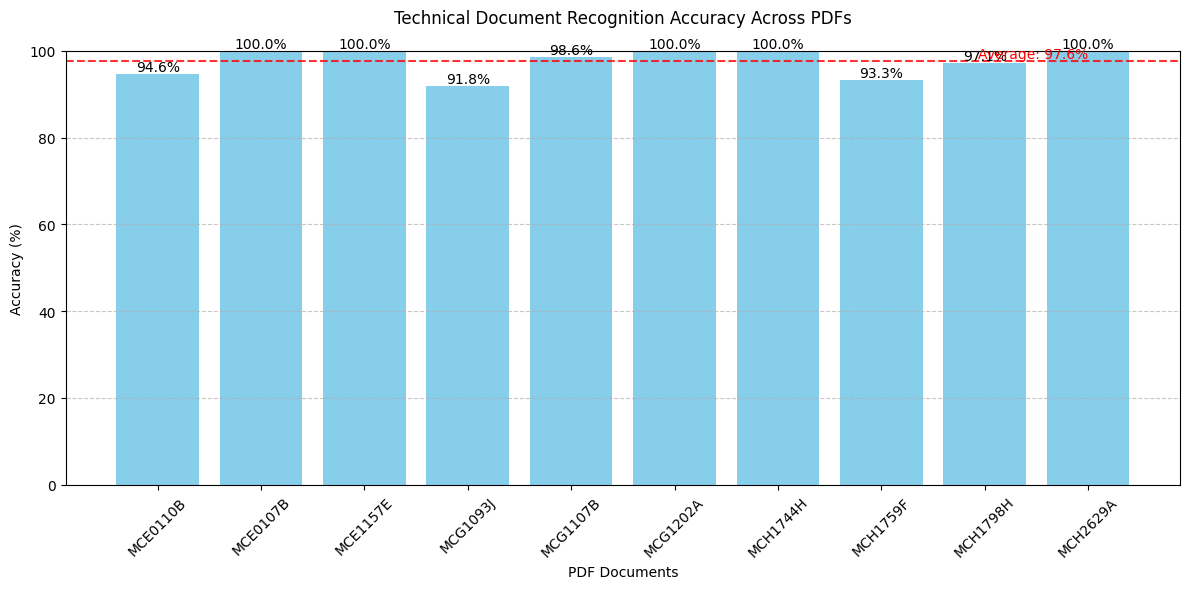

In [ ]:
import matplotlib.pyplot as plt
def main():
    nlp = create_nlp_pipeline()

    # Print results
    print("\nTechnical Document Recognition Validation")
    print("=" * 80)
    print(results_table)
    print(f"\nOverall Model Accuracy: {overall_accuracy:.1f}%")

    # Get accuracies for all PDFs
    accuracies = get_accuracies_for_all_pdfs(nlp)
    
    # Plot results
    plot_accuracies(accuracies)
    


if __name__ == "__main__":
    main()